In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import spearmanr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problem_sets.torch_problems import MengCase1
from mfbml.get_methods.accuracy_metrics import (
    log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)

# fix the random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# define function
func = MengCase1(noise_std=0.05)
num_dim = 1

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = lf_samples[::10]  # sample every 5 points

# generate responses
lf_responses = func.lf(lf_samples)
hf_responses = func.hf(hf_samples)

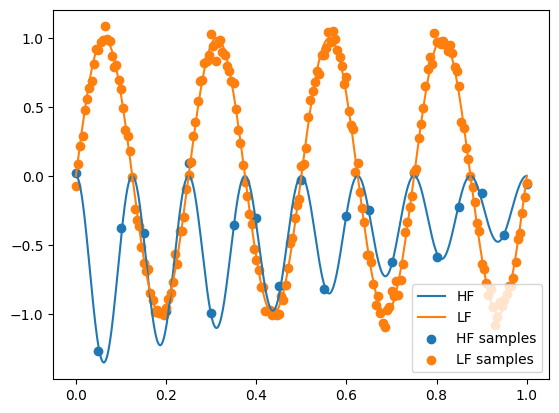

In [3]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf(test_samples, noise_lf=0.0)

# noise responses
test_hf_responses = func.hf(test_samples)
test_lf_responses = func.lf(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot test noisy responses
# ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
# ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [4]:
# calculate the person correlation coefficient via the noiseless responses
rho, pval = spearmanr(
    test_hf_responses_noiseless.numpy(), test_lf_responses_noiseless.numpy()
)
print("rho: ", rho)
print("pval: ", pval)

rho:  -0.08080117933899111
pval:  0.010545081375216493


## Configurations for DNN and BNNs


In [5]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {"batch_size": None, "num_epochs": 20000, "print_iter": 100}
hf_train_config = {
    "num_epochs": 50000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 30000,
}

### train standard BNN using HF data


In [6]:
# define BNN
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[50, 50],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=0.05,
)

# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses,
    num_epochs=50000,
    sample_freq=100,
    burn_in_epochs=30000,
)

epoch:     1/50000
nll_loss: 1599.520, prior_loss: 2507.730, total: 4107.250
noise: 0.050


/home/jiaxiangyi/Documents/mfbml/src/mfbml/methods/bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:   101/50000
nll_loss: 494.108, prior_loss: 2539.092, total: 3033.199
noise: 0.050
epoch:   201/50000
nll_loss: 471.930, prior_loss: 2569.483, total: 3041.413
noise: 0.050
epoch:   301/50000
nll_loss: 473.818, prior_loss: 2597.690, total: 3071.509
noise: 0.050
epoch:   401/50000
nll_loss: 480.672, prior_loss: 2631.592, total: 3112.264
noise: 0.050
epoch:   501/50000
nll_loss: 480.851, prior_loss: 2658.492, total: 3139.342
noise: 0.050
epoch:   601/50000
nll_loss: 470.770, prior_loss: 2697.327, total: 3168.097
noise: 0.050
epoch:   701/50000
nll_loss: 473.064, prior_loss: 2742.069, total: 3215.134
noise: 0.050
epoch:   801/50000
nll_loss: 473.441, prior_loss: 2783.529, total: 3256.970
noise: 0.050
epoch:   901/50000
nll_loss: 468.785, prior_loss: 2829.302, total: 3298.088
noise: 0.050
epoch:  1001/50000
nll_loss: 466.164, prior_loss: 2864.539, total: 3330.703
noise: 0.050
epoch:  1101/50000
nll_loss: 468.718, prior_loss: 2898.944, total: 3367.661
noise: 0.050
epoch:  1201/50000
nl

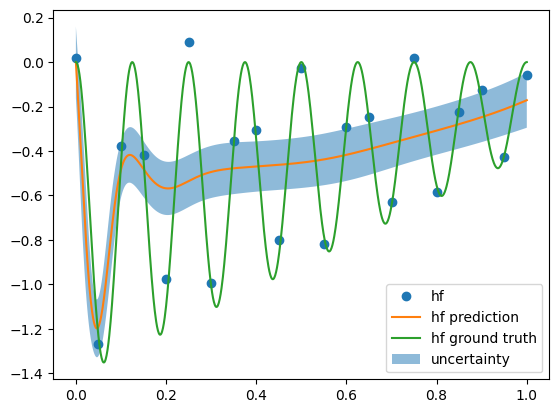

In [7]:
# visualize the posterior of bnn
bnn_y, bnn_epistemic, bnn_total_unc, bnn_aleatoric = bnn_model.predict(x=test_samples)

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
# plt.savefig("bnn.png", bbox_inches='tight', dpi=300)
plt.show()

# training of sequential MF-DNN-BNN model


In [8]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    lf_configure=lf_configure, hf_configure=hf_sequential_configure
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  99 loss:  0.48377230763435364
epoch:  199 loss:  0.48365089297294617
epoch:  299 loss:  0.4835279881954193
epoch:  399 loss:  0.48341402411460876
epoch:  499 loss:  0.4833086431026459
epoch:  599 loss:  0.483205646276474
epoch:  699 loss:  0.4830935597419739
epoch:  799 loss:  0.48294928669929504
epoch:  899 loss:  0.482715368270874
epoch:  999 loss:  0.48215869069099426
epoch:  1099 loss:  0.47821035981178284
epoch:  1199 loss:  0.4449467360973358
epoch:  1299 loss:  0.4183558225631714
epoch:  1399 loss:  0.39734888076782227
epoch:  1499 loss:  0.3576148748397827
epoch:  1599 loss:  0.2796173095703125
epoch:  1699 loss:  0.2216891348361969
epoch:  1799 loss:  0.10906487703323364
epoch:  1899 loss:  0.01989416405558586
epoch:  1999 loss:  0.013643351383507252
epoch:  2099 loss:  0.011153611354529858
epoch:  2199 loss:  0.009588050656020641
epoch:  2299 loss:  0.008409613743424416
epoch:  2399 loss:  0.007435009814798832
epoch:  2499 loss:  0.006584845948964357
epoch:  2599 loss

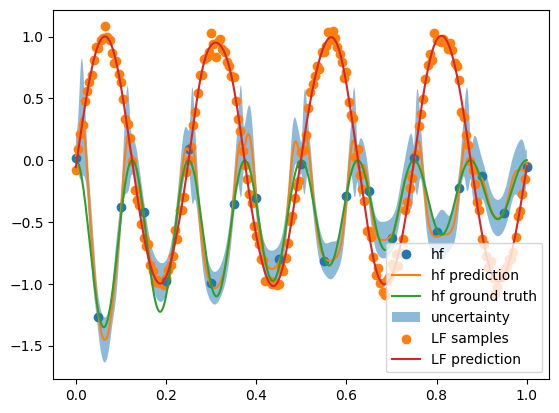

In [9]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.lf_model.forward(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(
    test_samples.numpy(), sequential_bnn_lf_y.detach().numpy(), label="LF prediction"
)
ax.legend()
plt.show()

In [10]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=False,
    beta_bounds=[-5, 5],
)
# define beta
mfdnnbnn.beta = np.array([3.0])
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.lf_model.forward(test_samples)

epoch:  99 loss:  0.48368096351623535
epoch:  199 loss:  0.4836065173149109
epoch:  299 loss:  0.4835357666015625
epoch:  399 loss:  0.4834558367729187
epoch:  499 loss:  0.4833683669567108
epoch:  599 loss:  0.4832727313041687
epoch:  699 loss:  0.4831649363040924
epoch:  799 loss:  0.4830362796783447
epoch:  899 loss:  0.4828683137893677
epoch:  999 loss:  0.4826198220252991
epoch:  1099 loss:  0.48218151926994324
epoch:  1199 loss:  0.4810844659805298
epoch:  1299 loss:  0.4727579653263092
epoch:  1399 loss:  0.44472670555114746
epoch:  1499 loss:  0.41649630665779114
epoch:  1599 loss:  0.40099668502807617
epoch:  1699 loss:  0.3918171525001526
epoch:  1799 loss:  0.3835704028606415
epoch:  1899 loss:  0.3757569491863251
epoch:  1999 loss:  0.3617812693119049
epoch:  2099 loss:  0.32448798418045044
epoch:  2199 loss:  0.2843523621559143
epoch:  2299 loss:  0.2662040889263153
epoch:  2399 loss:  0.24718664586544037
epoch:  2499 loss:  0.22245360910892487
epoch:  2599 loss:  0.204567

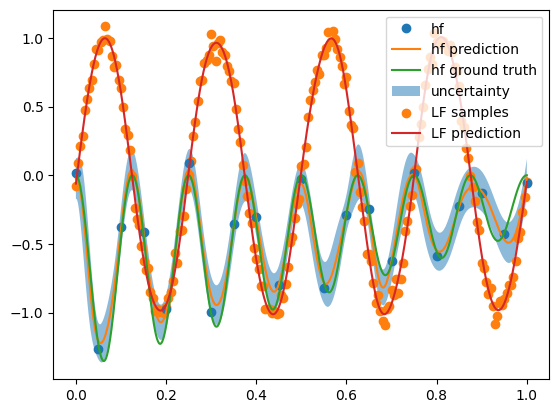

In [11]:
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax.legend()
plt.show()

In [27]:
# get the accuracy metrics
from sklearn.metrics import r2_score

print("=====================================")
print("BNN")
nrmse_bnn = normalized_rmse(test_hf_responses_noiseless.numpy(), bnn_y)
print("nrmse: ", nrmse_bnn)
nmae_bnn = normalized_mae(test_hf_responses_noiseless.numpy(), bnn_y)
print("nmae: ", nmae_bnn)
ll_bnn = log_likelihood_value(test_hf_responses.numpy(), bnn_y, bnn_total_unc)
print("ll_bnn: ", ll_bnn)
# r2 score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), bnn_y))
# sequential mf-bnn
print("=====================================")
print("Sequential MF-BNN")
nrmse_sequential_bnn = normalized_rmse(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nrmse: ", nrmse_sequential_bnn)
nmae_sequential_bnn = normalized_mae(
    test_hf_responses_noiseless.numpy(), sequential_bnn_y
)
print("nmae: ", nmae_sequential_bnn)
ll_sequential_bnn = log_likelihood_value(
    test_hf_responses.numpy(),
    sequential_bnn_y,
    sequential_bnn_total_unc,
)
print("ll_sequential_bnn: ", ll_sequential_bnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), sequential_bnn_y))
# MFDNNBNN
print("=====================================")
print("MFDNNBNN")
nrmse_mfdnnbnn = normalized_rmse(test_hf_responses_noiseless.numpy(), y_proposed)
print("nrmse: ", nrmse_mfdnnbnn)
nmae_mfdnnbnn = normalized_mae(test_hf_responses_noiseless.numpy(), y_proposed)
print("nmae: ", nmae_mfdnnbnn)
ll_mfdnnbnn = log_likelihood_value(
    test_hf_responses.numpy(), y_proposed, total_unc_proposed
)
print("ll_mfdnnbnn: ", ll_mfdnnbnn)
# R2 Score
print("=====================================")
print("R2 Score")
print("BNN: ", r2_score(test_hf_responses_noiseless.numpy(), y_proposed))

BNN
nrmse:  0.676135
nmae:  1.461706
ll_bnn:  -11945.334
R2 Score
BNN:  0.29606372376655166
Sequential MF-BNN
nrmse:  0.27050084
nmae:  1.1510553
ll_sequential_bnn:  625.312
R2 Score
BNN:  0.8873311979217158
MFDNNBNN
nrmse:  0.19822090711955934
nmae:  0.601412093938151
ll_mfdnnbnn:  672.9995152098479
R2 Score
BNN:  0.9394986028331948


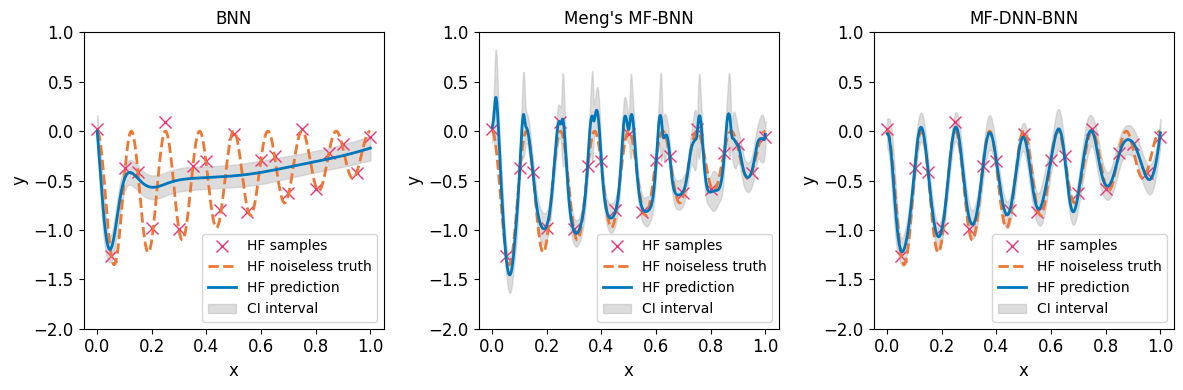

In [24]:
font_size = 12
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# plot results of bnn
ax[0].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[0].plot(
    test_samples.numpy(),
    bnn_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[0].fill_between(
    test_samples.flatten(),
    (bnn_y - 2 * bnn_total_unc).flatten(),
    (bnn_y + 2 * bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].legend(loc="lower right")
ax[0].set_title("BNN", fontsize=font_size)
ax[0].set_xlabel("x", fontsize=font_size)
ax[0].set_ylabel("y", fontsize=font_size)
ax[0].tick_params(labelsize=font_size)
ax[0].set_ylim([-2, 1.0])

#  plot for sequential mf-bnn
ax[1].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)

ax[1].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).flatten(),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1].legend(loc="lower right")
ax[1].set_title("Meng's MF-BNN", fontsize=font_size)
ax[1].set_xlabel("x", fontsize=font_size)
ax[1].set_ylabel("y", fontsize=font_size)
ax[1].tick_params(labelsize=font_size)
ax[1].set_ylim([-2, 1.0])

# plot for MFDNNBNN
ax[2].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)

ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).flatten(),
    (y_proposed + 2 * total_unc_proposed).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax[2].set_title("MF-DNN-BNN", fontsize=font_size)
ax[2].set_xlabel("x", fontsize=font_size)
ax[2].set_ylabel("y", fontsize=font_size)
ax[2].tick_params(labelsize=font_size)
ax[2].set_ylim([-2, 1.0])
ax[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig("mf_dnn_bnn_known_noise.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise.svg", dpi=300, bbox_inches="tight")
plt.show()

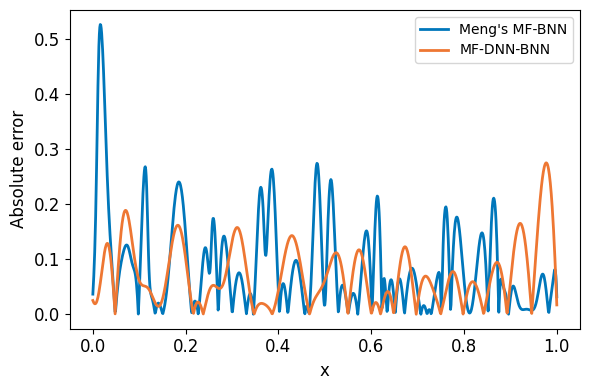

In [26]:
# error plot
fig, ax = plt.subplots(1, figsize=(6, 4))
# plot for sequential mf-bnn
ax.plot(
    test_samples.numpy(),
    np.abs(test_hf_responses_noiseless.numpy() - sequential_bnn_y),
    "-",
    color="#0077BB",
    linewidth=2,
    label="Meng's MF-BNN",
)
ax.plot(
    test_samples.numpy(),
    np.abs(test_hf_responses_noiseless.numpy() - y_proposed),
    "-",
    color="#EE7733",
    linewidth=2,
    label="MF-DNN-BNN",
)
ax.set_xlabel("x", fontsize=font_size)
ax.set_ylabel("Absolute error", fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend()
plt.tight_layout()
plt.savefig("mf_dnn_bnn_known_noise_error.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise_error.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_known_noise_error.svg", dpi=300, bbox_inches="tight")
plt.show()